In [ ]:
# Mueller Matrices + HERA Pixell (Optimal Map) Mosaic 

In [ ]:
### STILL INCOMPLETE ###

In [2]:
import numpy as np, healpy as hp, matplotlib.pyplot as plt
import os, sys, glob, yaml
from glob import glob
from pixell import enmap, utils, enplot
from astropy.io import fits
from astropy import wcs
from astropy.coordinates import SkyCoord, Galactic
from astropy import units as u


import pygsm,time,copy
import pyuvdata.utils as uvutils
import operator,subprocess,argparse
import json,itertools,shutil

import colorcet as cc
ccc = cc.m_cyclic_grey_15_85_c0_s25
import matplotlib
import cmocean

from astropy.coordinates import EarthLocation
from mpl_toolkits.axes_grid1 import AxesGrid
from matplotlib import gridspec
from pyuvdata import UVData
from datetime import datetime
from collections import OrderedDict as odict
from astropy.time import Time
from astropy_healpix import HEALPix
from astropy import constants as c
from copy import deepcopy
from sympy import *
init_printing(use_unicode=True)
from sympy.physics.quantum import TensorProduct

#
sys.path.insert(0,'/lustre/aoc/projects/hera/onevarez/cst2ijones')
from cst2ijones.jones_matrix_field  import InstrumentalJonesMatrixField
from cst2ijones.plotting import PlotMueller 
from cst2ijones import spherical_coordinates_basis_transformation as scbt

In [3]:
#wrapper for enmaps
def eshow(x,**kwargs): enplot.show(enplot.plot(x,**kwargs))

In [113]:
#Data paths

pbcorrmapdir = '/lustre/aoc/projects/hera/onevarez/pbcorrmapfits/'
pbcorrmapfits = glob(pbcorrmapdir+'zen.*')
pbcorrmapfits.sort()

#path = '/lustre/aoc/projects/hera/onevarez/imagefits/'
#fitsobjects = []
#fitsobjects= glob(path+'zen.*')
#fitsobjects.sort()


In [119]:
#OptimalMapCombination variables
#not sure if this cell is needed? (reference for now)

nx = npix
ny = npix
numstokes = 4
nmaps = len(pbcorrmapfits)

inx = 0
iny = 0

<b> The text below will caluclate the Jones and Mueller given the pbcorrmapfits.</b>

In [7]:
# given some frequency n, this function returns the proper file name.
def txtname(n):
    if n not in range(50,251):
        raise ValueError('no data at that frequency.')
    fname = '/lustre/aoc/projects/hera/onevarez/CST_Files/HERA_4.9m_E-pattern_{}MHz.txt'.format(str(n))
    
    return fname

# Pauli Spin Matricies 
def StokesMatrix(n):
    if n not in [0,1,2,3]: raise Exception('Input must be an integer in [0,1,2,3]')
    
    if n == 0:
        p = np.array([[1.,0],[0.,1.]])
    elif n == 1:
        p = np.array([[1.,0],[0,-1.]])
    elif n == 2:
        p = np.array([[0,1.],[1.,0]])
    elif n == 3:
        p = np.array([[0., -1j],[1j,0]])
    
    return p

# Build Mueller Matrix elements from the pauli spin matrix given some jones matrix, J, at a certain frequency.
def MuellerMatrixElement(J,i,j):
    
    Pi = StokesMatrix(i)
    Pj = StokesMatrix(j)
    
    M_ij = np.einsum('...ab,...bc,...cd,...ad',Pi,J,Pj,J.conj()) / 2. #fancy way of taking the transpose
    
    M_ij = np.real(M_ij)
    
    return M_ij


In [8]:
#change values below?

In [9]:
nu0 = 150
print ("nu0 = {}".format(nu0))
nu_nodes = range(nu0-5,nu0+6)

input_files = [txtname(n) for n in nu_nodes]

# Initialize the Jones matrix with data from simulation
J = InstrumentalJonesMatrixField(input_files, nu_nodes)

# Calculate how to rotate to HERA's latitude
lat = 120.7215 # units of degrees. Remember it runs from [90,-90] so 120deg == -30deg
z0_cza = np.radians(lat) # theta on the sphere is the polar angle
z0 = scbt.r_hat(z0_cza, 0.) # directional vector on sphere (sin(theta)cos(phi),sin(theta)sin(phi),cos(theta))
RotAxis = np.array([0,-1,0])
RotAngle = z0_cza
R_z0 = scbt.rotation_matrix(RotAxis, RotAngle)

nu_axis = np.array([nu0]) #np.linspace(nu0-1.,nu0+1., 3, endpoint=True)

nu0 = 150


In [114]:
# BUILD PROPER GRID SIZE
# Determine the proper theta (rad) and phi (rad) values for a Sky Coordinate
# value at a specific HealPix pixel value.
#fitsobject = path+'zen.2458098.52817.HH.calibrated.uvh5.image.image.fits'

ijones_sq= []

for pbcorrmapfit in pbcorrmapfits:
    # Load the FITS hdulits
    data, header = fits.getdata(pbcorrmapfit, header=True)
    #header['CRVAL1'] = 0.


    # Parse the WCS keywords in the primary HDU
    w = wcs.WCS(header)

    # This won't work for rectangular images
    npix_sq = header['NAXIS1']

    # Convert Equitorial Coordinates to Spherical Coordinates grid
    xpix, ypix = np.meshgrid(np.arange(npix_sq),np.arange(npix_sq), indexing='xy')
    #np.meshgrid(np.arange(1,npix+1),np.arange(1,npix+1), indexing='xy')
    # Should we start from 0 or 1?  aagh
    #Right ascension and declination as seen on the inside of the celestial sphere
    ra, dec, dummy_freq, dummy_stokes = w.all_pix2world(xpix, ypix,1,1,1) 
    c_icrs = SkyCoord(ra=ra*u.degree, dec=dec*u.degree, frame='icrs') # Coordinates Object

    # Convert ra/dec to phi/theta
    # don't use ravel because altering the values could change the original data.
    theta_grid = np.pi/2. - c_icrs.dec.radian 
    theta_flat = np.reshape(theta_grid,-1)

    #phi_grid = np.radians(header['CRVAL1']) - c_icrs.ra.radian # azimuthal angle limits [0,2*np.pi]
    phi_grid = c_icrs.ra.radian.mean() - c_icrs.ra.radian
    phi_flat = np.reshape(phi_grid,-1)

    # Calculate rotation around -y (?) to get the beam to point at declination = latitude
    z0_cza = np.radians(120.7215)
    RotAxis = np.array([0,-1,0])
    RotAngle = z0_cza
    R_z0 = scbt.rotation_matrix(RotAxis, RotAngle)

    theta_hor, phi_hor = scbt.spherical_coordinates_map(R_z0, theta_flat, phi_flat)
    phi_hor = 2.*np.pi - phi_hor
    ijones_sq.append(np.reshape(J(nu_axis, theta_hor, phi_hor, R_z0.T),(len(nu_axis),npix_sq, npix_sq, 2, 2)))


Set OBSGEO-B to   -30.721389 from OBSGEO-[XYZ].
Set OBSGEO-H to     1496.994 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


In [116]:
print(ijones_sq[1].shape)

#will make pStokes here

pStokes = np.ones([nx,ny,numstokes,nmaps])
#pStokes will be 512, 512, 2+2, nmaps(54)
pStokes

(1, 512, 512, 2, 2)


In [117]:
# Generate Simulation of the Mueller Matrix
i_index,j_index = 4,4
nchan = len(nu_axis)
npix = 512
#MuellerMatrixij_sq = np.zeros((i_index,j_index,nchan,npix,npix),dtype=np.float64) # [i,j, freq,ra pixel,dec pixel]
#new_MuellerMatrix = np.zeros((512,512,1,4,4),dtype=np.float64)
#ii_index = [0,0,0,0,1,1,1,1,2,2,2,2,3,3,3,3]
#jj_index = [0,1,2,3,0,1,2,3,0,1,2,3,0,1,2,3]

new_mmatrices = []
mmatrix = []
filenames = []
ijonesindex = 0

for ijones in ijones_sq:
    new_MuellerMatrix = np.zeros((npix,npix,nchan,i_index,j_index),dtype=np.float64)
    for f in range(ijones.shape[0]):
        for i in range(i_index):
            for j in range(j_index):
               #MuellerMatrixij_sq[i,j,f,:,:] = MuellerMatrixElement(ijones_sq[f],i,j)
                new_MuellerMatrix[:,:,f,i,j] = MuellerMatrixElement(ijones[f],i,j)
    new_mmatrices.append(new_MuellerMatrix)
                
    #PrimaryHDU
    hdu = fits.PrimaryHDU(data=new_MuellerMatrix,header=header)
    for k in header.keys():
        if k == '':
            continue
        if k == 'HISTORY':
            continue
        hdu.header.append((k,header[k]))
        
        #will create fits per mueller matrix (16 per pixel)

    for i,j in zip(iarr,jarr):
        mmatrix.append(fits.PrimaryHDU(data=hdu.data[i][j][0][:][:],header=hdu.header))
        filenames.append('/lustre/aoc/projects/hera/onevarez/mmatrixfits/MuellerMatrixBeam_{}_{}_{}_{}MHz.fits'.format(ijonesindex,i,j,nu0))
    ijonesindex+=1
    
    
for m,files in zip(range(len(mmatrix)),filenames):        
    mmatrix[m].writeto(files,overwrite=True)

# write new GSM model out to a FITS file
##mb_filename='/home/onevarez/MuellerMatrixInverter/new_MuellerMatrix_{}MHz.fits'.format(nu0)
##hdu.writeto(mb_filename,overwrite=True)
##mb = fits.open(mb_filename)
##mb[0].header['CTYPE4']='Mueller Components' # Change the name
##mb.writeto(mb_filename,overwrite=True)

In [83]:
new_mmatrices[1]

array([[[[[ 8.11852384e-04, -1.60895319e-04, -4.45966948e-05,
           -1.45276773e-05],
          [ 6.64677994e-06, -6.05525309e-05,  3.31762764e-04,
           -7.19255247e-04],
          [ 1.67219723e-04, -7.88314573e-04, -1.92275772e-04,
           -2.38677045e-05],
          [-8.97812418e-06, -1.78319653e-04,  6.97115078e-04,
            3.36645729e-04]]],


        [[[ 7.93261132e-04, -1.60615278e-04, -4.48671771e-05,
           -1.23955650e-05],
          [ 5.74679584e-06, -6.49192414e-05,  3.24537272e-04,
           -7.01279772e-04],
          [ 1.66957904e-04, -7.68874141e-04, -1.93930890e-04,
           -1.99386172e-05],
          [-7.48423233e-06, -1.78085812e-04,  6.78512103e-04,
            3.30548067e-04]]],


        [[[ 7.75051427e-04, -1.60073505e-04, -4.51015872e-05,
           -1.03730570e-05],
          [ 4.92599624e-06, -6.90846727e-05,  3.17751760e-04,
           -6.83538460e-04],
          [ 1.66445960e-04, -7.49806719e-04, -1.95371195e-04,
           -1.623800

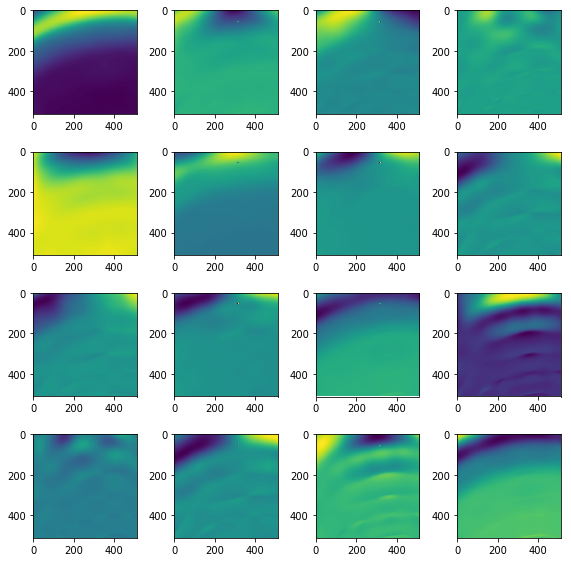

In [118]:
#below will plot (just to check)

iarr = [0,0,0,0,1,1,1,1,2,2,2,2,3,3,3,3]
jarr = [0,1,2,3,0,1,2,3,0,1,2,3,0,1,2,3]
f,axarr = plt.subplots(4,4,sharex=True,sharey=True,figsize=(8,8))
gs = gridspec.GridSpec(4,4)#, wspace=0.01, hspace=0.1)


for i in range(len(iarr)):
    
    ax=plt.subplot(gs[iarr[i],jarr[i]])
    ax.imshow(new_mmatrices[0][:,:,0,iarr[i],jarr[i]])
plt.tight_layout()

#f.savefig('/Users/tashaleebillings/Desktop/research/images/MuellerMatrix_usingAstropy.png')
plt.show()

In [ ]:
#matrices above seem wrong. 

<b>The text below comes from BeamDividedPixelMosaic. Uses pbcorrmaps.</b>

In [109]:
#this will define master map dimensions + mastermap
   
pbcorrmapfit = pbcorrmapfits[0]
   
pbcorrmap1 = enmap.read_map(pbcorrmapfit,)
#hdu = fits.open(pbcorrmap1)
pix_fac = 2.
pixsize_new = np.abs(pbcorrmap1.wcs.pixel_scale_matrix[0][0])*60./pix_fac * utils.arcmin
shape_band, wcs_band = enmap.band_geometry(np.radians([-41,-21]), 
                                               res=pixsize_new, proj='car') #shape=shape_fullsky, proj='car')
print(shape_band)
print(wcs_band)
mastermap = enmap.enmap(np.zeros(shape_band), wcs=wcs_band)

Set OBSGEO-B to   -30.721389 from OBSGEO-[XYZ].
Set OBSGEO-H to     1496.994 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


(288, 5184)
WCS Transformation

This transformation has 2 pixel and 2 world dimensions

Array shape (Numpy order): None

Pixel Dim  Data size  Bounds
        0       None  None
        1       None  None

World Dim  Physical Type  Units
        0  pos.eq.ra      deg
        1  pos.eq.dec     deg

Correlation between pixel and world axes:

           Pixel Dim
World Dim    0    1
        0  yes  yes
        1  yes  yes


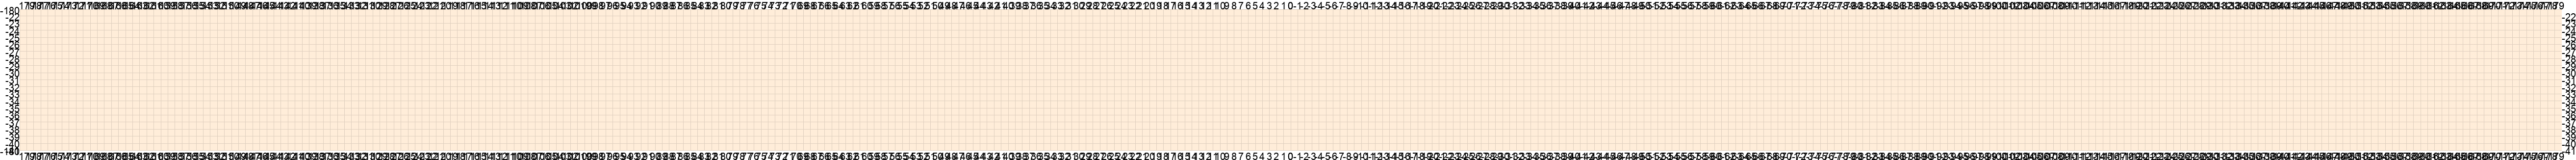

In [110]:
eshow(mastermap)

In [111]:
#this will now apply each fits onto the mastermap (not sure if needed?)
stampmapsI=stampmapsQ=stampmapsU=stampmapsV=[]

mastermapI=mastermapQ=mastermapU=mastermapV = mastermap

for pbcorrmapfit in pbcorrmapfits:
    print(pbcorrmapfit)
    pbcorrmap1 = enmap.read_map(pbcorrmapfit,)
    
    #add matrices calc. here 
    stokesI = pbcorrmap1[0,0,:,:]
    
    stokesQ = pbcorrmap1[1,0,:,:]
    stokesU = pbcorrmap1[2,0,:,:]
    stokesV = pbcorrmap1[3,0,:,:]
    
    # Also get the necessary fits information
    hdu = fits.open(pbcorrmapfit)
    
    # Extract a postage stamp centered on the center of the image
    dec0, ra0 = np.deg2rad(np.array((hdu[0].header['CRVAL2'],hdu[0].header['CRVAL1'])))
    width = np.deg2rad(5.)
    
    # [[decfrom,rafrom],[[decto,rato]]
    box = np.array([[dec0-width/2.,ra0-width/2.],[dec0+width/2.,ra0+width/2.]])
    #print(dec,ra,width)
    
 
    #print(box)
    stampI = stokesI.submap(box)
    
    stampQ = stokesQ.submap(box)
    stampU = stokesU.submap(box)
    stampV = stokesV.submap(box)
    
    #enplot.write('test',enplot.plot(stamp))
  
    # project the stamp into the master grid
    stampmapI = enmap.project(stampI, shape_band, wcs_band)
    
    stampmapQ = enmap.project(stampQ, shape_band, wcs_band)
    stampmapU = enmap.project(stampU, shape_band, wcs_band)
    stampmapV = enmap.project(stampV, shape_band, wcs_band)
    
    stampmapsI.append(stampmapI)
    
    stampmapsQ.append(stampmapQ)
    stampmapsU.append(stampmapU)
    stampmapsV.append(stampmapV)
    
    # Accumulate
    mastermapI += stampmapI
    
    mastermapQ += stampmapQ
    mastermapU += stampmapU
    mastermapV += stampmapV

/lustre/aoc/projects/hera/onevarez/pbcorrmapfits/zen.2458098.22991.HH.calibrated.uvh5.image.pbcorrmap.fits


Set OBSGEO-B to   -30.721389 from OBSGEO-[XYZ].
Set OBSGEO-H to     1496.994 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


/lustre/aoc/projects/hera/onevarez/pbcorrmapfits/zen.2458098.23737.HH.calibrated.uvh5.image.pbcorrmap.fits


Set OBSGEO-B to   -30.721389 from OBSGEO-[XYZ].
Set OBSGEO-H to     1496.994 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


/lustre/aoc/projects/hera/onevarez/pbcorrmapfits/zen.2458098.24482.HH.calibrated.uvh5.image.pbcorrmap.fits


Set OBSGEO-B to   -30.721389 from OBSGEO-[XYZ].
Set OBSGEO-H to     1496.994 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


/lustre/aoc/projects/hera/onevarez/pbcorrmapfits/zen.2458098.25228.HH.calibrated.uvh5.image.pbcorrmap.fits


Set OBSGEO-B to   -30.721389 from OBSGEO-[XYZ].
Set OBSGEO-H to     1496.994 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


/lustre/aoc/projects/hera/onevarez/pbcorrmapfits/zen.2458098.25974.HH.calibrated.uvh5.image.pbcorrmap.fits


Set OBSGEO-B to   -30.721389 from OBSGEO-[XYZ].
Set OBSGEO-H to     1496.994 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


/lustre/aoc/projects/hera/onevarez/pbcorrmapfits/zen.2458098.26719.HH.calibrated.uvh5.image.pbcorrmap.fits


Set OBSGEO-B to   -30.721389 from OBSGEO-[XYZ].
Set OBSGEO-H to     1496.994 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


/lustre/aoc/projects/hera/onevarez/pbcorrmapfits/zen.2458098.27465.HH.calibrated.uvh5.image.pbcorrmap.fits


Set OBSGEO-B to   -30.721389 from OBSGEO-[XYZ].
Set OBSGEO-H to     1496.994 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


/lustre/aoc/projects/hera/onevarez/pbcorrmapfits/zen.2458098.28211.HH.calibrated.uvh5.image.pbcorrmap.fits


Set OBSGEO-B to   -30.721389 from OBSGEO-[XYZ].
Set OBSGEO-H to     1496.994 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


/lustre/aoc/projects/hera/onevarez/pbcorrmapfits/zen.2458098.28956.HH.calibrated.uvh5.image.pbcorrmap.fits


Set OBSGEO-B to   -30.721389 from OBSGEO-[XYZ].
Set OBSGEO-H to     1496.994 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


/lustre/aoc/projects/hera/onevarez/pbcorrmapfits/zen.2458098.29702.HH.calibrated.uvh5.image.pbcorrmap.fits


Set OBSGEO-B to   -30.721389 from OBSGEO-[XYZ].
Set OBSGEO-H to     1496.994 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


/lustre/aoc/projects/hera/onevarez/pbcorrmapfits/zen.2458098.30448.HH.calibrated.uvh5.image.pbcorrmap.fits


Set OBSGEO-B to   -30.721389 from OBSGEO-[XYZ].
Set OBSGEO-H to     1496.994 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


/lustre/aoc/projects/hera/onevarez/pbcorrmapfits/zen.2458098.31193.HH.calibrated.uvh5.image.pbcorrmap.fits


Set OBSGEO-B to   -30.721389 from OBSGEO-[XYZ].
Set OBSGEO-H to     1496.994 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


/lustre/aoc/projects/hera/onevarez/pbcorrmapfits/zen.2458098.31939.HH.calibrated.uvh5.image.pbcorrmap.fits


Set OBSGEO-B to   -30.721389 from OBSGEO-[XYZ].
Set OBSGEO-H to     1496.994 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


/lustre/aoc/projects/hera/onevarez/pbcorrmapfits/zen.2458098.32685.HH.calibrated.uvh5.image.pbcorrmap.fits


Set OBSGEO-B to   -30.721389 from OBSGEO-[XYZ].
Set OBSGEO-H to     1496.994 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


/lustre/aoc/projects/hera/onevarez/pbcorrmapfits/zen.2458098.33430.HH.calibrated.uvh5.image.pbcorrmap.fits


Set OBSGEO-B to   -30.721389 from OBSGEO-[XYZ].
Set OBSGEO-H to     1496.994 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


/lustre/aoc/projects/hera/onevarez/pbcorrmapfits/zen.2458098.34176.HH.calibrated.uvh5.image.pbcorrmap.fits


Set OBSGEO-B to   -30.721389 from OBSGEO-[XYZ].
Set OBSGEO-H to     1496.994 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


/lustre/aoc/projects/hera/onevarez/pbcorrmapfits/zen.2458098.34922.HH.calibrated.uvh5.image.pbcorrmap.fits


Set OBSGEO-B to   -30.721389 from OBSGEO-[XYZ].
Set OBSGEO-H to     1496.994 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


/lustre/aoc/projects/hera/onevarez/pbcorrmapfits/zen.2458098.35667.HH.calibrated.uvh5.image.pbcorrmap.fits


Set OBSGEO-B to   -30.721389 from OBSGEO-[XYZ].
Set OBSGEO-H to     1496.994 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


/lustre/aoc/projects/hera/onevarez/pbcorrmapfits/zen.2458098.37159.HH.calibrated.uvh5.image.pbcorrmap.fits


Set OBSGEO-B to   -30.721389 from OBSGEO-[XYZ].
Set OBSGEO-H to     1496.994 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


/lustre/aoc/projects/hera/onevarez/pbcorrmapfits/zen.2458098.37904.HH.calibrated.uvh5.image.pbcorrmap.fits


Set OBSGEO-B to   -30.721389 from OBSGEO-[XYZ].
Set OBSGEO-H to     1496.994 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


/lustre/aoc/projects/hera/onevarez/pbcorrmapfits/zen.2458098.38650.HH.calibrated.uvh5.image.pbcorrmap.fits


Set OBSGEO-B to   -30.721389 from OBSGEO-[XYZ].
Set OBSGEO-H to     1496.994 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


/lustre/aoc/projects/hera/onevarez/pbcorrmapfits/zen.2458098.39395.HH.calibrated.uvh5.image.pbcorrmap.fits


Set OBSGEO-B to   -30.721389 from OBSGEO-[XYZ].
Set OBSGEO-H to     1496.994 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


/lustre/aoc/projects/hera/onevarez/pbcorrmapfits/zen.2458098.40141.HH.calibrated.uvh5.image.pbcorrmap.fits


Set OBSGEO-B to   -30.721389 from OBSGEO-[XYZ].
Set OBSGEO-H to     1496.994 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


/lustre/aoc/projects/hera/onevarez/pbcorrmapfits/zen.2458098.40887.HH.calibrated.uvh5.image.pbcorrmap.fits


Set OBSGEO-B to   -30.721389 from OBSGEO-[XYZ].
Set OBSGEO-H to     1496.994 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


/lustre/aoc/projects/hera/onevarez/pbcorrmapfits/zen.2458098.41632.HH.calibrated.uvh5.image.pbcorrmap.fits


Set OBSGEO-B to   -30.721389 from OBSGEO-[XYZ].
Set OBSGEO-H to     1496.994 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


/lustre/aoc/projects/hera/onevarez/pbcorrmapfits/zen.2458098.42378.HH.calibrated.uvh5.image.pbcorrmap.fits


Set OBSGEO-B to   -30.721389 from OBSGEO-[XYZ].
Set OBSGEO-H to     1496.994 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


/lustre/aoc/projects/hera/onevarez/pbcorrmapfits/zen.2458098.43124.HH.calibrated.uvh5.image.pbcorrmap.fits


Set OBSGEO-B to   -30.721389 from OBSGEO-[XYZ].
Set OBSGEO-H to     1496.994 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


/lustre/aoc/projects/hera/onevarez/pbcorrmapfits/zen.2458098.43869.HH.calibrated.uvh5.image.pbcorrmap.fits


Set OBSGEO-B to   -30.721389 from OBSGEO-[XYZ].
Set OBSGEO-H to     1496.994 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


/lustre/aoc/projects/hera/onevarez/pbcorrmapfits/zen.2458098.44615.HH.calibrated.uvh5.image.pbcorrmap.fits


Set OBSGEO-B to   -30.721389 from OBSGEO-[XYZ].
Set OBSGEO-H to     1496.994 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


/lustre/aoc/projects/hera/onevarez/pbcorrmapfits/zen.2458098.45361.HH.calibrated.uvh5.image.pbcorrmap.fits


Set OBSGEO-B to   -30.721389 from OBSGEO-[XYZ].
Set OBSGEO-H to     1496.994 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


/lustre/aoc/projects/hera/onevarez/pbcorrmapfits/zen.2458098.46106.HH.calibrated.uvh5.image.pbcorrmap.fits


Set OBSGEO-B to   -30.721389 from OBSGEO-[XYZ].
Set OBSGEO-H to     1496.994 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


/lustre/aoc/projects/hera/onevarez/pbcorrmapfits/zen.2458098.46852.HH.calibrated.uvh5.image.pbcorrmap.fits


Set OBSGEO-B to   -30.721389 from OBSGEO-[XYZ].
Set OBSGEO-H to     1496.994 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


/lustre/aoc/projects/hera/onevarez/pbcorrmapfits/zen.2458098.47598.HH.calibrated.uvh5.image.pbcorrmap.fits


Set OBSGEO-B to   -30.721389 from OBSGEO-[XYZ].
Set OBSGEO-H to     1496.994 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


/lustre/aoc/projects/hera/onevarez/pbcorrmapfits/zen.2458098.48343.HH.calibrated.uvh5.image.pbcorrmap.fits


Set OBSGEO-B to   -30.721389 from OBSGEO-[XYZ].
Set OBSGEO-H to     1496.994 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


/lustre/aoc/projects/hera/onevarez/pbcorrmapfits/zen.2458098.49089.HH.calibrated.uvh5.image.pbcorrmap.fits


Set OBSGEO-B to   -30.721389 from OBSGEO-[XYZ].
Set OBSGEO-H to     1496.994 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


/lustre/aoc/projects/hera/onevarez/pbcorrmapfits/zen.2458098.49835.HH.calibrated.uvh5.image.pbcorrmap.fits


Set OBSGEO-B to   -30.721389 from OBSGEO-[XYZ].
Set OBSGEO-H to     1496.994 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


/lustre/aoc/projects/hera/onevarez/pbcorrmapfits/zen.2458098.50580.HH.calibrated.uvh5.image.pbcorrmap.fits


Set OBSGEO-B to   -30.721389 from OBSGEO-[XYZ].
Set OBSGEO-H to     1496.994 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


/lustre/aoc/projects/hera/onevarez/pbcorrmapfits/zen.2458098.51326.HH.calibrated.uvh5.image.pbcorrmap.fits


Set OBSGEO-B to   -30.721389 from OBSGEO-[XYZ].
Set OBSGEO-H to     1496.994 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


/lustre/aoc/projects/hera/onevarez/pbcorrmapfits/zen.2458098.52072.HH.calibrated.uvh5.image.pbcorrmap.fits


Set OBSGEO-B to   -30.721389 from OBSGEO-[XYZ].
Set OBSGEO-H to     1496.994 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


/lustre/aoc/projects/hera/onevarez/pbcorrmapfits/zen.2458098.52817.HH.calibrated.uvh5.image.pbcorrmap.fits


Set OBSGEO-B to   -30.721389 from OBSGEO-[XYZ].
Set OBSGEO-H to     1496.994 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


/lustre/aoc/projects/hera/onevarez/pbcorrmapfits/zen.2458098.53563.HH.calibrated.uvh5.image.pbcorrmap.fits


Set OBSGEO-B to   -30.721389 from OBSGEO-[XYZ].
Set OBSGEO-H to     1496.994 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


/lustre/aoc/projects/hera/onevarez/pbcorrmapfits/zen.2458098.54309.HH.calibrated.uvh5.image.pbcorrmap.fits


Set OBSGEO-B to   -30.721389 from OBSGEO-[XYZ].
Set OBSGEO-H to     1496.994 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


/lustre/aoc/projects/hera/onevarez/pbcorrmapfits/zen.2458098.55054.HH.calibrated.uvh5.image.pbcorrmap.fits


Set OBSGEO-B to   -30.721389 from OBSGEO-[XYZ].
Set OBSGEO-H to     1496.994 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


/lustre/aoc/projects/hera/onevarez/pbcorrmapfits/zen.2458098.55800.HH.calibrated.uvh5.image.pbcorrmap.fits


Set OBSGEO-B to   -30.721389 from OBSGEO-[XYZ].
Set OBSGEO-H to     1496.994 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


/lustre/aoc/projects/hera/onevarez/pbcorrmapfits/zen.2458098.56546.HH.calibrated.uvh5.image.pbcorrmap.fits


Set OBSGEO-B to   -30.721389 from OBSGEO-[XYZ].
Set OBSGEO-H to     1496.994 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


/lustre/aoc/projects/hera/onevarez/pbcorrmapfits/zen.2458098.57291.HH.calibrated.uvh5.image.pbcorrmap.fits


Set OBSGEO-B to   -30.721389 from OBSGEO-[XYZ].
Set OBSGEO-H to     1496.994 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


/lustre/aoc/projects/hera/onevarez/pbcorrmapfits/zen.2458098.58037.HH.calibrated.uvh5.image.pbcorrmap.fits


Set OBSGEO-B to   -30.721389 from OBSGEO-[XYZ].
Set OBSGEO-H to     1496.994 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


/lustre/aoc/projects/hera/onevarez/pbcorrmapfits/zen.2458098.58782.HH.calibrated.uvh5.image.pbcorrmap.fits


Set OBSGEO-B to   -30.721389 from OBSGEO-[XYZ].
Set OBSGEO-H to     1496.994 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


/lustre/aoc/projects/hera/onevarez/pbcorrmapfits/zen.2458098.59528.HH.calibrated.uvh5.image.pbcorrmap.fits


Set OBSGEO-B to   -30.721389 from OBSGEO-[XYZ].
Set OBSGEO-H to     1496.994 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


/lustre/aoc/projects/hera/onevarez/pbcorrmapfits/zen.2458098.60274.HH.calibrated.uvh5.image.pbcorrmap.fits


Set OBSGEO-B to   -30.721389 from OBSGEO-[XYZ].
Set OBSGEO-H to     1496.994 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


/lustre/aoc/projects/hera/onevarez/pbcorrmapfits/zen.2458098.61019.HH.calibrated.uvh5.image.pbcorrmap.fits


Set OBSGEO-B to   -30.721389 from OBSGEO-[XYZ].
Set OBSGEO-H to     1496.994 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


/lustre/aoc/projects/hera/onevarez/pbcorrmapfits/zen.2458098.61765.HH.calibrated.uvh5.image.pbcorrmap.fits


Set OBSGEO-B to   -30.721389 from OBSGEO-[XYZ].
Set OBSGEO-H to     1496.994 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


/lustre/aoc/projects/hera/onevarez/pbcorrmapfits/zen.2458098.62511.HH.calibrated.uvh5.image.pbcorrmap.fits


Set OBSGEO-B to   -30.721389 from OBSGEO-[XYZ].
Set OBSGEO-H to     1496.994 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


/lustre/aoc/projects/hera/onevarez/pbcorrmapfits/zen.2458098.63256.HH.calibrated.uvh5.image.pbcorrmap.fits


Set OBSGEO-B to   -30.721389 from OBSGEO-[XYZ].
Set OBSGEO-H to     1496.994 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


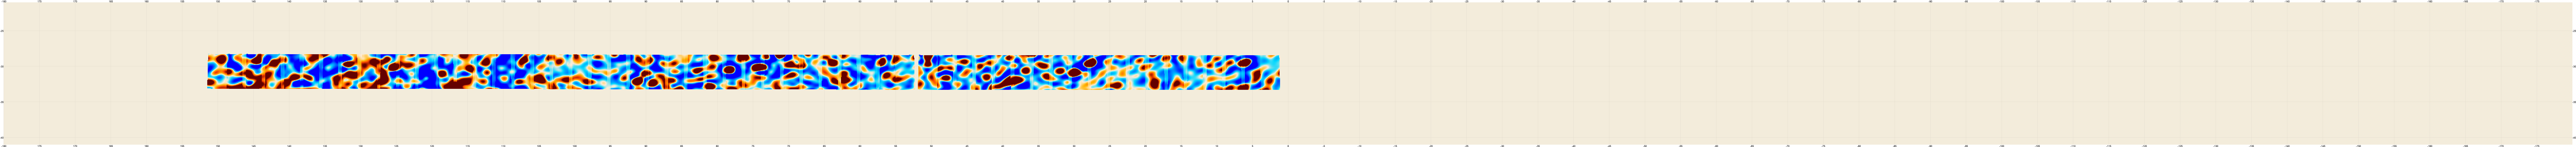

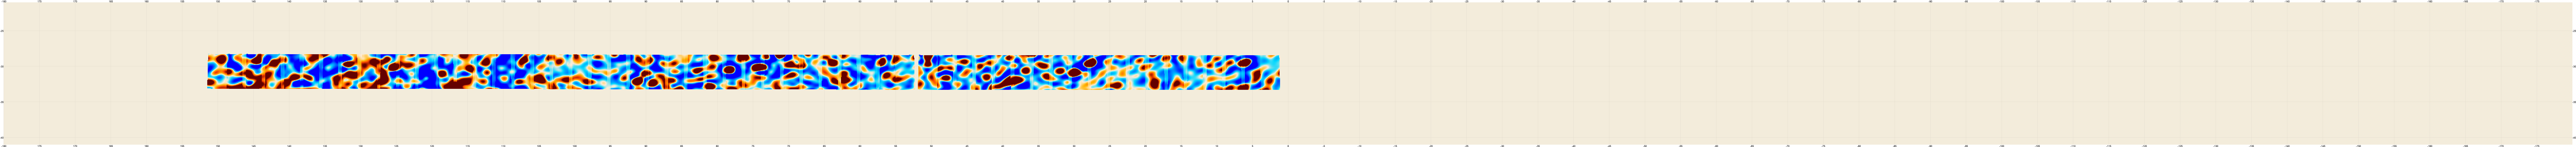

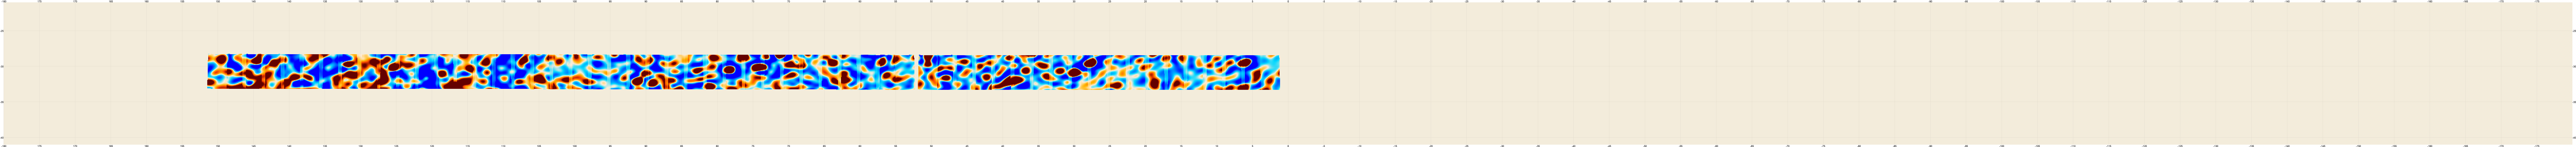

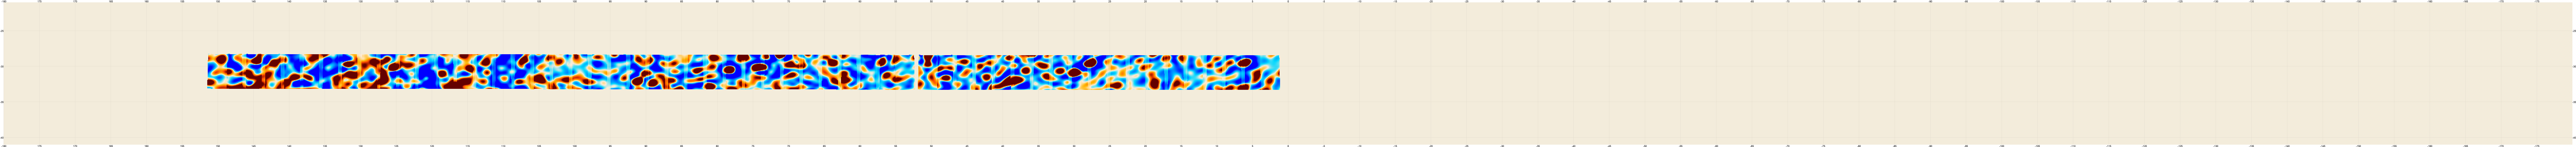

In [112]:
#to check and see if the mastermaps turned out right

enplot.show(enplot.plot(mastermapI,ticks=5,upgrade=4))
enplot.show(enplot.plot(mastermapQ,ticks=5,upgrade=4))
enplot.show(enplot.plot(mastermapU,ticks=5,upgrade=4))
enplot.show(enplot.plot(mastermapV,ticks=5,upgrade=4))

In [ ]:
#mastermaps above seems wrong

<b> The following code modified from OptimalMapCombinations. Connected to BeamDividedPixelMosaic. </b>

In [73]:
# Let's assumed we have a stack of maps, each of 4 pseudo Stokes parameters, 
# and a corresponding stack of Mueller matrices
nx = npix
ny = npix
numstokes = 4
nmaps = len(pbcorrmapfits)
pStokes = np.ones([nx,ny,numstokes,nmaps])  
Mueller = np.ones([nx,ny,stokes,numstokes,nmaps]) #[divisions vertically, groups per division, matrices per group, numbers vertically, numbers horizontally ]
Stokes = np.ones([nx,ny,numstokes,nmaps])

In [74]:
inx = 0
iny = 0
ndata = 4*nmaps

##test code below
#print(pStokes.shape)
idx1= [2,3,0,1]
#pStokes1=[[pStokes[i][j] for j in idx1] for i in idx1]
##pStokes1=np.ones((stokes,nmaps,nx,ny),dtype=np.float64)
#print(pStokes.shape,pStokes)


In [50]:
# Construct A and the data
A = np.zeros([ndata,4]) # mueller matrix * 54 maps (in 54*4 by 4)
d = np.zeros([ndata]) # pStokes * 54 maps (I q u v, all in one horiz. line)
for imap in np.arange(nmaps):
    indx = np.arange(imap*4, (imap+1)*4)
    A[indx, :] = Mueller[inx, iny, :, :, imap]
    d[indx] = pStokes[inx, iny, :, imap]

In [53]:
# We will probably always assume W is diagonal; but there might be noise correlation between the pseudo-Stokes ... ?
## ignore for now... 
W = np.ones([ndata,ndata]) 

In [59]:
# Check that everything is the right shape
ATWd = np.matmul(A.T, np.matmul(W,d))
Cov = np.matmul(A.T, np.matmul(W, A))
# Need to think about computing the condition number and the inversion method here
invCov = Cov #np.linalg.inv(Cov)

In [69]:
bestfit = np.matmul(invCov, ATWd) #

In [70]:
print(bestfit.shape)

(4,)
